<a href="https://colab.research.google.com/github/anton1evdokimov/0_project-1.-Who-Wants-to-Become-a-Film-Millionaire/blob/main/Satellite_segmentation_17_05_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install segmentation_models_pytorch

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107

In [2]:
# %cd /content/drive/MyDrive/Computer_Vision/SatelliteDataset/images/train
# !ls

In [3]:
import albumentations as A
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import re

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
def load_mask(path: str):
    mask = Image.open(path)
    mask = np.array(mask)/255
    mask = mask.transpose((2,0,1))
    new_channel = np.where(np.sum(mask,axis=0) == 0, 1, 0)
    mask = np.concatenate([mask, new_channel[None,:,:]])
    return mask.transpose((1,2,0))

def load_image(path: str):
    img = Image.open(path)
    img = np.array(img)/255

    image_without_alpha = img[:,:,:3]

    return image_without_alpha

# %cd /content/drive/MyDrive/Computer_Vision/SatelliteDataset/mask/train
# mask_data = {}
# for index, p in enumerate(os.listdir()):
#   img = load_image(p)
#   print(index, mask_data)
#   ground = 0
#   pixel_sum = 0
#   for i in range(3):
#     sum1 = sum(list(img[:,:,i].ravel()))
#     pixel_sum += sum1
#     mask_data[i] = mask_data.setdefault(i,0) + sum1

#   ground = 1280*720 - pixel_sum
#   mask_data["ground"] = mask_data.setdefault('ground',0) + ground

In [6]:
configs = {
    "dataset_dir": "/content/drive/MyDrive/Computer_Vision/SatelliteDataset",
    "pad_shape": (9,9,6,6),
    "train_batch_size": 4,
    "shuffle": True,
    "init_lr": 0.001,
    "epochs": 10
}

In [7]:
def sortByNumber(path):
  return int(re.findall(r'\d+', path)[0])

IMAGE_HEIGHT=180
IMAGE_WIDTH=270

class SatelliteDataset():
    def __init__(self, ds_type = "train", path=configs['dataset_dir'], pad_shape = configs['pad_shape']):

        self.ds_type = ds_type
        self.img_dir = os.path.join(path, f"images/{ds_type}")
        self.mask_dir = os.path.join(path, f"mask/{ds_type}")
        self.pad_shape = pad_shape

        self.img_pathes = []
        self.mask_pathes = []

        for file_path in os.walk(self.img_dir):
            self.img_pathes.extend(list(filter(lambda x: x.endswith(".png"), file_path[-1])))

        for file_path in os.walk(self.mask_dir):
            self.mask_pathes.extend(list(filter(lambda x: x.endswith(".png"), file_path[-1])))

        self.img_pathes.sort(key=sortByNumber, reverse=False)
        self.mask_pathes.sort(key=sortByNumber, reverse=False)

    def __getitem__(self, index):
        mask_path = self.mask_pathes[index]
        img_path = self.img_pathes[index]

        mask = load_mask(os.path.join(self.mask_dir, mask_path))
        img = load_image(os.path.join(self.img_dir, img_path))
        a1 = []
        if self.ds_type == "train":
          a1 = [
                A.RandomCrop(p=0.025, height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
                A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
                # A.RandomRotate90(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                # A.Transpose(p=0.03),
                A.OneOf([
                  A.ElasticTransform(p=0.05, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                  A.GridDistortion(p=0.05),
                  A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
                  ], p=0.08)
            ]
        else:
            a1 = [
                A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            ]

        aug = A.Compose(
            a1,
            is_check_shapes=False
          )
        aug_data = aug(image=img, mask=mask)
        img = aug_data['image']
        mask = aug_data['mask']

        pad_transform = torch.nn.ZeroPad2d(self.pad_shape)
        img = pad_transform(torch.FloatTensor(img.transpose((2,0,1))))
        mask = pad_transform(torch.FloatTensor(mask.transpose((2,0,1))))

        return img, mask

    def __len__(self):
        return len(self.img_pathes)

In [8]:
train_dataset = SatelliteDataset(ds_type = "train", path = configs['dataset_dir'])
val_dataset = SatelliteDataset(ds_type = "val", path = configs['dataset_dir'])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=configs['train_batch_size'], shuffle=configs['shuffle'])
val_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=configs['train_batch_size'], shuffle=configs['shuffle'])

In [9]:
# kf = {0: 149146755.0, 1: 186089625.0, 2: 13564157.0, 'ground': 1969945063.0}

ground = 0.006885550899243528
k2 = 1
k1 = 0.07289045265151134
k0 = 0.09094503598150694

In [10]:
import segmentation_models_pytorch as smp

model = smp.Unet('resnet50', encoder_weights='imagenet', in_channels=3, classes=4, activation='softmax')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=configs['init_lr'])

params = torch.tensor([k0, k1, k2, ground]).to(device)
loss = torch.nn.CrossEntropyLoss(params)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 325MB/s]


In [11]:
for epoch in range(configs['epochs']):
  loss_list = []

  for img, mask in train_dataloader:
    img = img.to(device)

    mask = mask.to(device)

    predict = model(img)
    loss_value = loss(mask, predict)

    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()

    print(f"loss: {loss_value.item()}")
    loss_list.append(loss_value.item())

  print(f"main loss##################: {np.mean(loss_list)}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


loss: 0.26844272017478943
loss: 0.23620690405368805
loss: 0.21691180765628815
loss: 0.1905422955751419
loss: 0.17673541605472565
loss: 0.1593824326992035
loss: 0.14640069007873535
loss: 0.13619443774223328
loss: 0.1238921508193016
loss: 0.11841922998428345
loss: 0.11171723902225494
loss: 0.10470233857631683
loss: 0.10138135403394699
loss: 0.09830436110496521
loss: 0.09185303747653961
loss: 0.08909621834754944
loss: 0.08733906596899033
loss: 0.08446716517210007
loss: 0.08074919134378433
loss: 0.08172713220119476
loss: 0.07661936432123184
loss: 0.07235174626111984
loss: 0.0763731375336647
loss: 0.07205627858638763
loss: 0.06919725239276886
loss: 0.06680373102426529
loss: 0.06594227999448776
loss: 0.06414420902729034
loss: 0.06187080219388008
loss: 0.061712443828582764
loss: 0.05881144478917122
loss: 0.06074702367186546
loss: 0.058599118143320084
loss: 0.05900317803025246
loss: 0.057822611182928085
loss: 0.0518379844725132
loss: 0.05127137154340744
loss: 0.0526779480278492
loss: 0.0523289

KeyboardInterrupt: 

In [12]:
state_dict = model.state_dict()
torch.save(state_dict,'model_weights_17.05.2024.pth')
# w = torch.load('model_weights.pth', map_location=torch.device('cpu'))
# model.load_state_dict(w)

mIoU > 0.70

In [13]:
def calc_IoU(mask, predict):

  mask = np.array(torch.argmax(mask, dim=0))
  predict = np.array(torch.argmax(predict, dim=0))

  IoU = []
  for i in range(4):
    m = np.where(mask == i, 1, 0)
    p = np.where(predict == i, 1, 0)
    inters = np.sum(m * p)
    IoU.append(inters/(np.sum(m)+np.sum(p)-inters))

  return np.mean(IoU)

In [ ]:
loss_list = []
mIoU = []

for img, mask in val_dataloader:
    img = img.to(device)
    mask = mask.to(device)

    predict = model(img)

    loss_value = loss(mask, predict)
    loss_list.append(loss_value.item())

    mask = mask.to('cpu')
    predict = predict.to('cpu')
    loss_list.append(loss_value.item())

    for index in range(configs['train_batch_size']):
      mIoU.append(calc_IoU(mask[index], predict[index]))

    print(f"mIoU: {np.mean(mIoU)}")

# print(f"loss: {np.mean(loss_list)}")



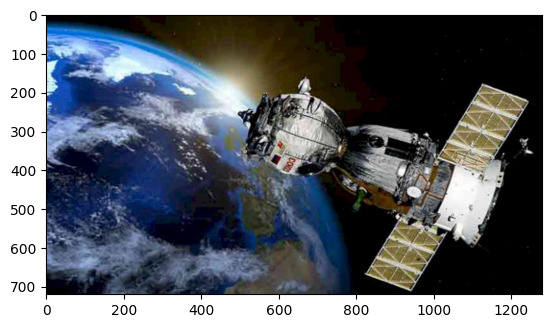

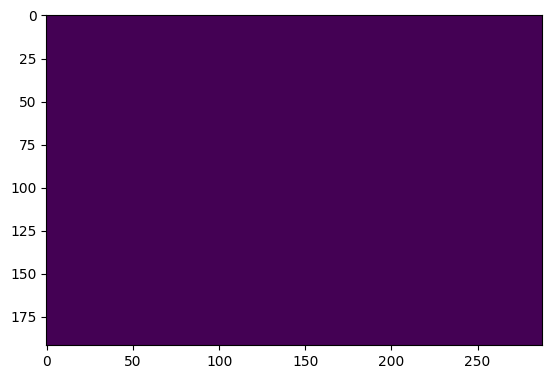

In [17]:
def load(path):
  img = load_image(path)
  aug = A.Compose(
      [A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH)],
      is_check_shapes=False
  )
  aug_data = aug(image=img)
  img = aug_data['image']
  pad_transform = torch.nn.ZeroPad2d((9,9,6,6))
  plt.imshow(load_image(path))
  plt.show()

  return pad_transform(torch.FloatTensor(img.transpose((2,0,1))))

img = load(os.path.join(configs['dataset_dir'], "images/train", 'img_resize_0.png'))

model = model.to('cpu')

plt.imshow(torch.argmax(model(img[None,:,:,:])[0], dim = 0))


In [ ]:
img = load_image(os.path.join(configs['dataset_dir'], "mask/train", 'img_resize_0_mask.png'))


In [ ]:
len(set(list(img[:,:,0].ravel())))

2

/content/drive/.shortcut-targets-by-id/1XxbZ5nhdF1CdLX3VwUhJdgY5IJTHXohw/mask/train


In [42]:
len(os.listdir())

2517

In [ ]:
plt.imshow(load_image(os.path.join(configs['dataset_dir'], "images/train", 'img_resize_0.png')))

In [ ]:
load_image(os.path.join(configs['dataset_dir'], "images/train", 'img_resize_0.png'))

NameError: name 'configs' is not defined